# Basic example using the MOSM, Conv, CSM and SM-LMC kernels
Here we show the basic usage of the toolkit using a contrived example dataset of three sinusoidal signals. The three sinusses are each put in a channel and have the same frequency but differ in phase. The observations are randomly picked in the range of [0,4], where the first channel will have the second half of the observations removed. Each of the kernels is being evaluated on the same dataset so that we can easily compare the results. Finally, a comparison is made between the different kernels and the errors they obtain.

In [47]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk
import numpy as np

# TODO: remove when done:
%reload_ext autoreload
%autoreload 2

## Generate dataset

In [48]:
data = mogptk.Data()

data.add_function(lambda x: np.sin(6*x), n=20, start=0.0, end=4.0, var=0.03, name='A')
data.add_function(lambda x: np.sin(6*x)+2, n=20, start=0.0, end=4.0, var=0.03, name='B')
data.add_function(lambda x: np.sin(6*x)+2 - np.sin(4*x), n=20, start=0.0, end=4.0, var=0.03, name='C')

data.remove_range('A', start=2.0, end=None)

## MOSM

In [42]:
model_mosm = mogptk.MOSM(data, Q=3)
model_mosm.init_params()
display(model_mosm.get_params())

BNSE [[[ 5.49035439  1.83011813 10.06564971]]]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -17.405508
  Number of iterations: 63
  Number of functions evaluations: 83


BNSE [[[6.30470784 6.44211142 6.30464371]]]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -24.366452
  Number of iterations: 71
  Number of functions evaluations: 135


BNSE [[[4.02989148 5.64184807 4.1291429 ]]]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -3.284793
  Number of iterations: 192
  Number of functions evaluations: 238


[{'magnitude': array([4.97365389e-01, 5.26361985e-01, 3.31718403e-04]),
  'mean': array([[5.97444263e+00, 6.00242680e+00, 6.63231708e-06]]),
  'variance': array([[1.00000000e-06, 1.00289812e-06, 1.38829249e-06]]),
  'delay': array([[0., 0., 0.]]),
  'phase': array([0., 0., 0.]),
  'noise': array([0.65605944, 0.3335017 , 0.66332368])},
 {'magnitude': array([1.00000000e-06, 1.00004534e-06, 2.82545931e+00]),
  'mean': array([[2.76165450e+03, 4.62902700e-04, 4.98522921e+00]]),
  'variance': array([[1.56621223e+02, 2.54600933e-05, 7.97768019e-02]]),
  'delay': array([[0., 0., 0.]]),
  'phase': array([0., 0., 0.]),
  'noise': array([0.39109913, 0.37924848, 0.84280423])},
 {'magnitude': array([1.00000000e-06, 4.02660260e+00, 4.00962432e+00]),
  'mean': array([[4.42561645e+02, 5.84236265e-04, 9.17429100e-03]]),
  'variance': array([[1.55136516e+02, 1.04658067e-03, 8.47238163e-06]]),
  'delay': array([[0., 0., 0.]]),
  'phase': array([0., 0., 0.]),
  'noise': array([0.40328641, 0.03914736, 0.39

In [19]:
model_mosm.train()
display(model_mosm.get_params())

Building...


Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -42.572545
  Number of iterations: 1000
  Number of functions evaluations: 1212
Done


[{'magnitude': array([19.79490945,  1.46337935,  3.2918111 ]),
  'mean': array([[ 5.97521025e+00, -2.15014382e-02,  3.25749804e-03]]),
  'variance': array([[1.00000000e-06, 1.01885997e-06, 1.09616597e-06]]),
  'delay': array([[ 0.00000000e+00, -1.15354274e-05,  1.15354274e-05]]),
  'phase': array([ 0.        , -0.00010454,  0.00010454]),
  'noise': array([1.41102815e-05, 9.31309334e-01, 1.03605074e-01])},
 {'magnitude': array([-3.54755054e-04,  1.16957863e+01,  1.36934430e+00]),
  'mean': array([[56.54545883,  6.00294087,  4.97440791]]),
  'variance': array([[1.00000000e-06, 3.63840092e-06, 2.68286937e-01]]),
  'delay': array([[ 0.        ,  1.76931862, -1.76931862]]),
  'phase': array([  0.        , -10.63351801,  10.63351801]),
  'noise': array([2.35022351e-05, 4.39394311e+00, 1.73851127e+00])},
 {'magnitude': array([-1.93468378e-05,  2.59557898e-02, -3.02688193e-02]),
  'mean': array([[ 1.61250237e+03,  3.92721578e-03, -3.43504939e-03]]),
  'variance': array([[8.68067757e+02, 2.2305

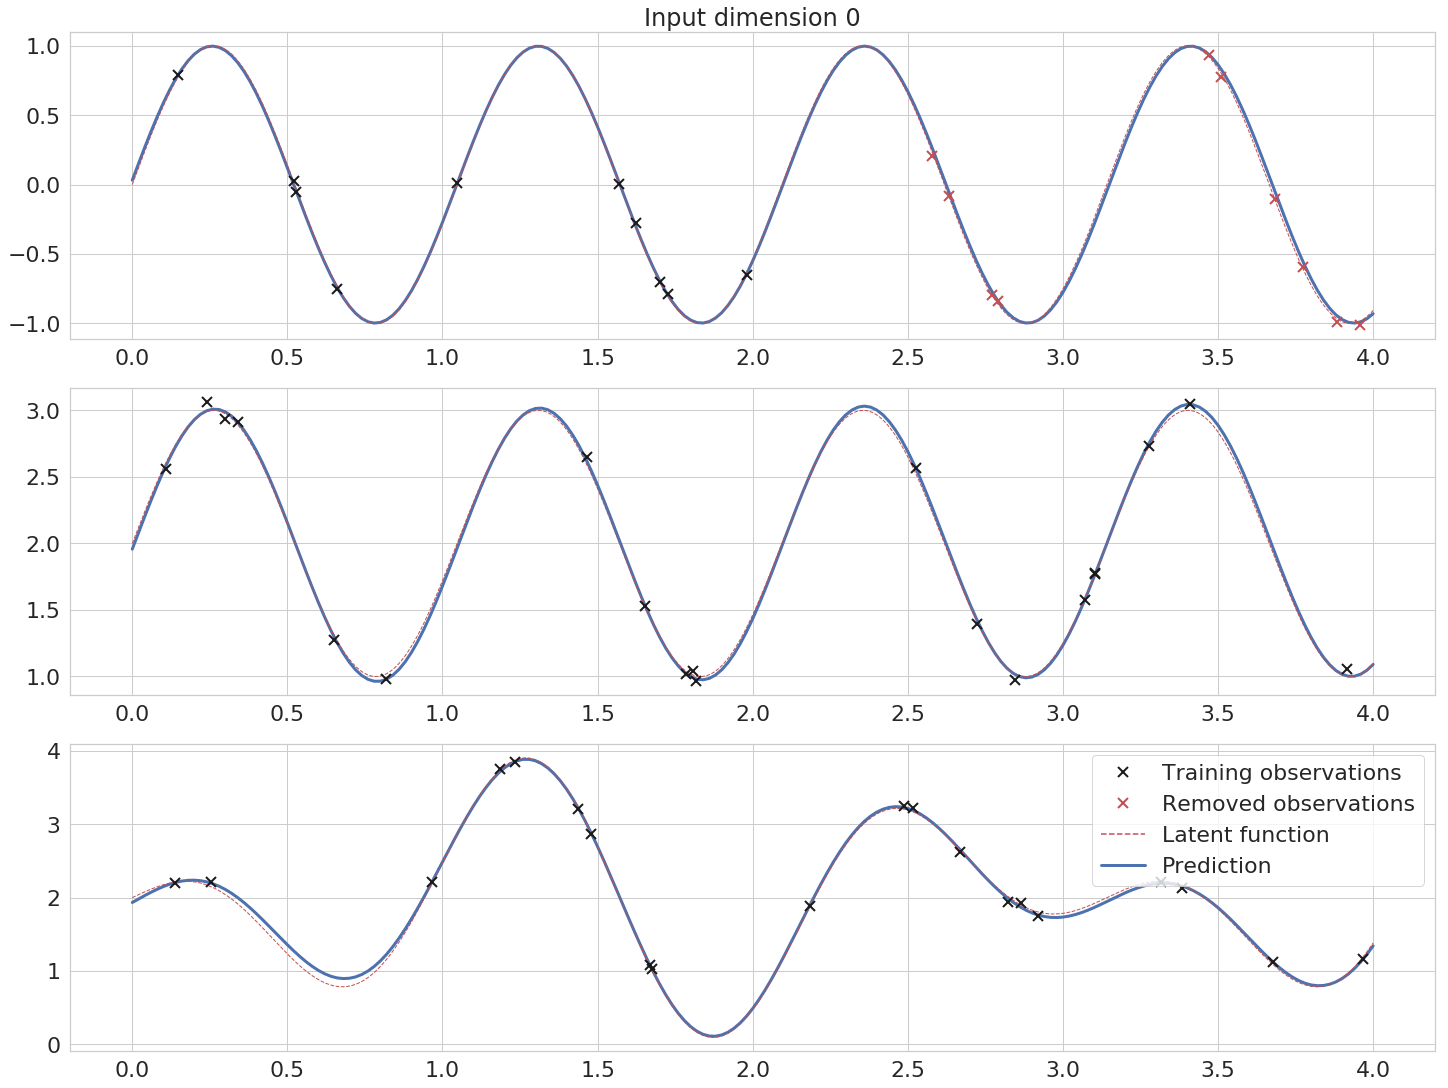

In [20]:
model_mosm.set_prediction_range(channel='A', start=0, end=4, step=0.02)
model_mosm.set_prediction_range(channel='B', start=0, end=4, step=0.02)
model_mosm.set_prediction_range(channel='C', start=0, end=4, step=0.02)
model_mosm.predict()

mogptk.plot(model_mosm)

## CSM

In [59]:
model_csm = mogptk.CSM(data, Q=3)
model_csm.init_params()
display(model_csm.get_params())

BNSE [[[5.16009101 4.8550722  5.22018649]]]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -28.565965
  Number of iterations: 47
  Number of functions evaluations: 59


BNSE [[[5.63904365 2.34960152 3.60272233]]]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -58.264196
  Number of iterations: 119
  Number of functions evaluations: 232


BNSE [[[3.49344385 2.1834024  5.67684625]]]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -53.367951
  Number of iterations: 87
  Number of functions evaluations: 105
[{'weight': array([[1.25921011e-05, 2.23546488e-02, 2.22794824e-02]]), 'mean': array([[3.72752792e-05, 5.98828111e+00, 5.98591554e+00]]), 'scale': array([[1.10384720e-05, 1.00002664e-06, 1.00000000e-06]])}, {'weight': array([[0.02202637, 0.35038995, 0.34774294]]), 'mean': array([[6.03948094e+00, 6.28326528e-06, 6.28318531e-06]]), 'scale': array([[1.00001268e-06, 1.00000016e-06, 1.00000000e-06]])}, {'weight': array([[2.61527949e-02, 6.27787166e-05, 2.28321847e-02]]), 'mean': array([[6.28318569e-06, 7.18698821e+01, 4.01242877e+00]]), 'scale': array([[1.00128720e-06, 7.11062036e-01, 1.00043030e-06]])}]
0.0002820386401295188
0.030585415317515224
0.5332108095232948
0.5007007710477708
0.48654508679376424
0.0012799507817827331
0.4990171903120997
0.48286

[{'constant': array([[0.30187636, 0.13762168, 0.40672263]]),
  'mean': array([6.28318569e-06]),
  'variance': array([1.0012872e-06]),
  'phase': array([[0., 0., 0.]])},
 {'constant': array([[0.69956125, 0.51469812, 0.88772121]]),
  'mean': array([5.98828111]),
  'variance': array([1.00002664e-06]),
  'phase': array([[0., 0., 0.]])},
 {'constant': array([[0.74143502, 0.10653264, 0.68996899]]),
  'mean': array([5.98591554]),
  'variance': array([1.e-06]),
  'phase': array([[0., 0., 0.]])}]

In [60]:
model_csm.train()
display(model_csm.get_params())

Building...


Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -80.967718
  Number of iterations: 411
  Number of functions evaluations: 467
Done


[{'constant': array([[1.84594883e-05, 3.56782354e+00, 3.55143011e+00]]),
  'mean': array([6.26293559e-06]),
  'variance': array([1.00119611e-06]),
  'phase': array([[1.e-06, 1.e-06, 1.e-06]])},
 {'constant': array([[1.00000000e-06, 1.00760334e-06, 5.82532607e-01]]),
  'mean': array([4.00772233]),
  'variance': array([1.00002663e-06]),
  'phase': array([[1.e-06, 1.e-06, 1.e-06]])},
 {'constant': array([[0.48116841, 0.49414157, 0.48459638]]),
  'mean': array([5.99254595]),
  'variance': array([1.e-06]),
  'phase': array([[1.e-06, 1.e-06, 1.e-06]])}]

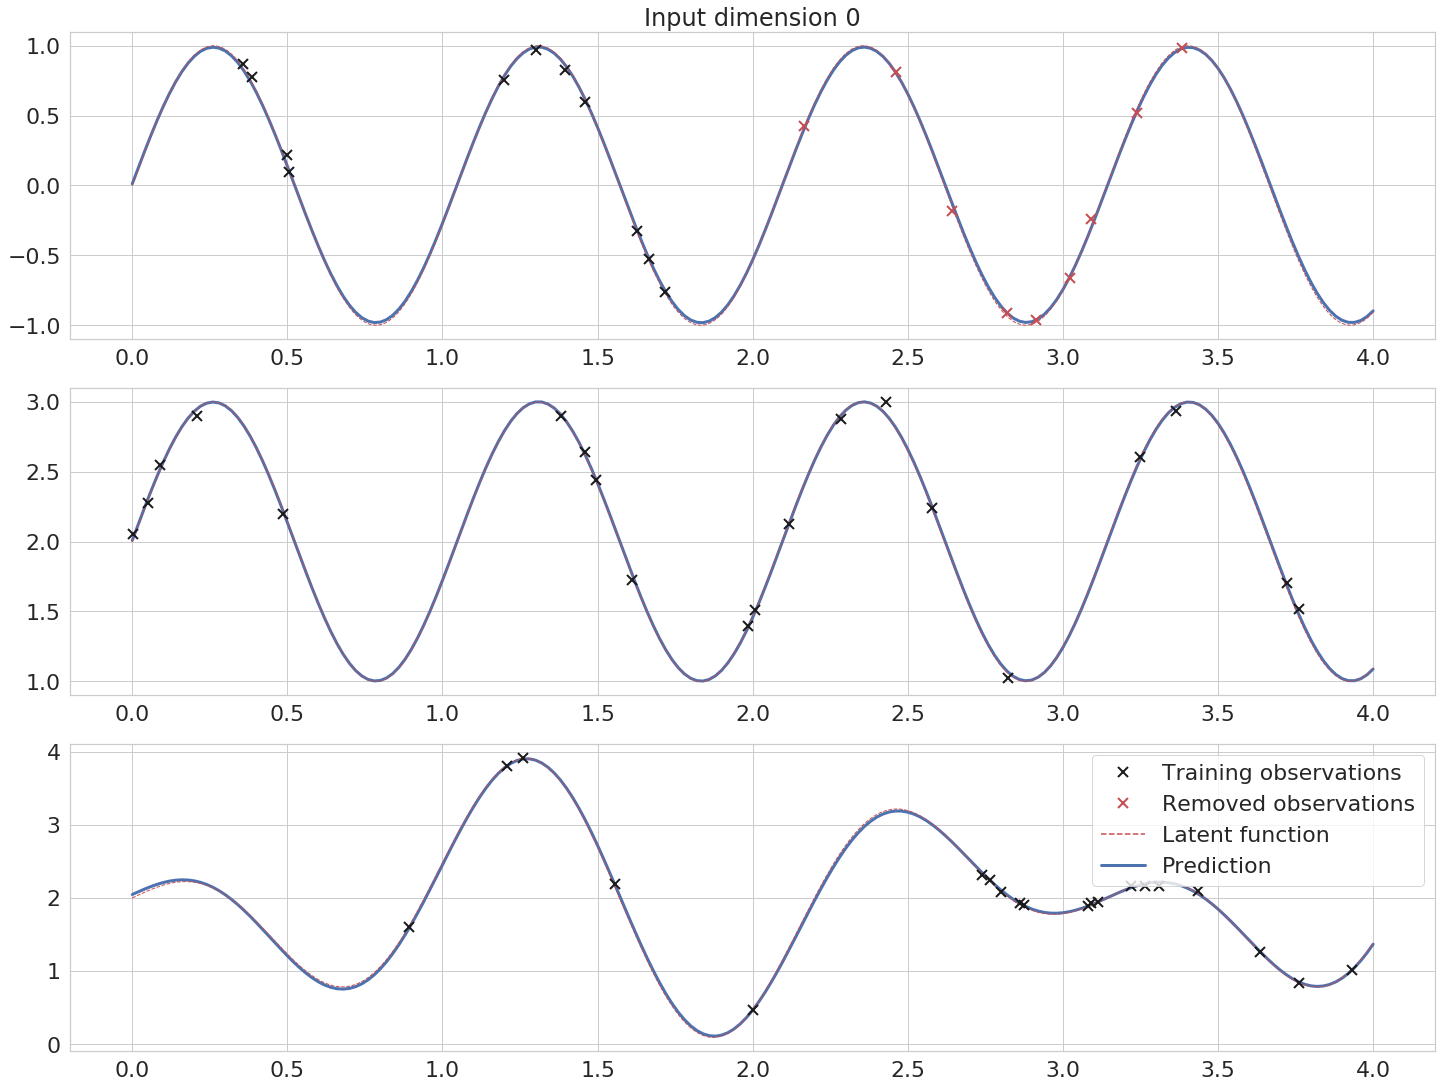

In [61]:
model_csm.set_prediction_range(channel='A', start=0, end=4, step=0.02)
model_csm.set_prediction_range(channel='B', start=0, end=4, step=0.02)
model_csm.set_prediction_range(channel='C', start=0, end=4, step=0.02)
model_csm.predict()

mogptk.plot(model_csm)

## CG

In [23]:
model_cg = mogptk.CG(data, Q=3)
model_cg.init_params()
display(model_cg.get_params())

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -17.405508
  Number of iterations: 82
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 5.352800
  Number of iterations: 44
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -16.506083
  Number of iterations: 77
  Number of functions evaluations: 90


[{'constant': array([0.54011515, 0.05429708, 0.33738397]),
  'variance': array([[1.15107493e-06, 1.37232010e-06, 1.00000000e-06]])},
 {'constant': array([0.83403373, 0.5603317 , 0.43505745]),
  'variance': array([[1.00031535e-06, 4.87612085e-01, 1.00002195e-06]])},
 {'constant': array([0.00125584, 0.43743706, 0.77508384]),
  'variance': array([[1.86542209e-06, 2.56472707e-06, 1.00000000e-06]])}]

In [24]:
model_cg.train()
display(model_cg.get_params())

Building...


Optimizing...


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[node GPR-c034ed87-369/likelihood_1/Cholesky (defined at /home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/models/gpr.py:64) ]]

Caused by op 'GPR-c034ed87-369/likelihood_1/Cholesky', defined at:
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-871236c88604>", line 1, in <module>
    model_cg.train()
  File "../mogptk/model.py", line 185, in train
    self.build(kind, disp)
  File "../mogptk/model.py", line 128, in build
    self.model = gpflow.models.GPR(x, y, self._kernel())
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/models/gpr.py", line 64, in _build_likelihood
    L = tf.cholesky(K)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 767, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[node GPR-c034ed87-369/likelihood_1/Cholesky (defined at /home/taco/anaconda3/envs/py36/lib/python3.6/site-packages/gpflow/models/gpr.py:64) ]]


In [ ]:
model_cg.set_prediction_range(channel='A', start=0, end=4, step=0.02)
model_cg.set_prediction_range(channel='B', start=0, end=4, step=0.02)
model_cg.set_prediction_range(channel='C', start=0, end=4, step=0.02)
model_cg.predict()

mogptk.plot(model_cg)

## SM-LMC

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -28.565965
  Number of iterations: 44
  Number of functions evaluations: 58
82.0432736397012


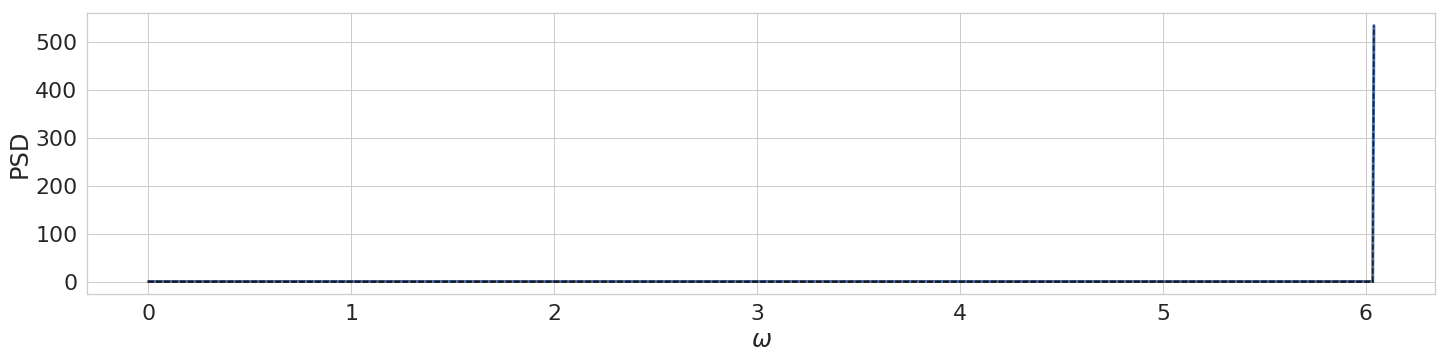

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -58.264196
  Number of iterations: 70
  Number of functions evaluations: 121
24.905116362213953


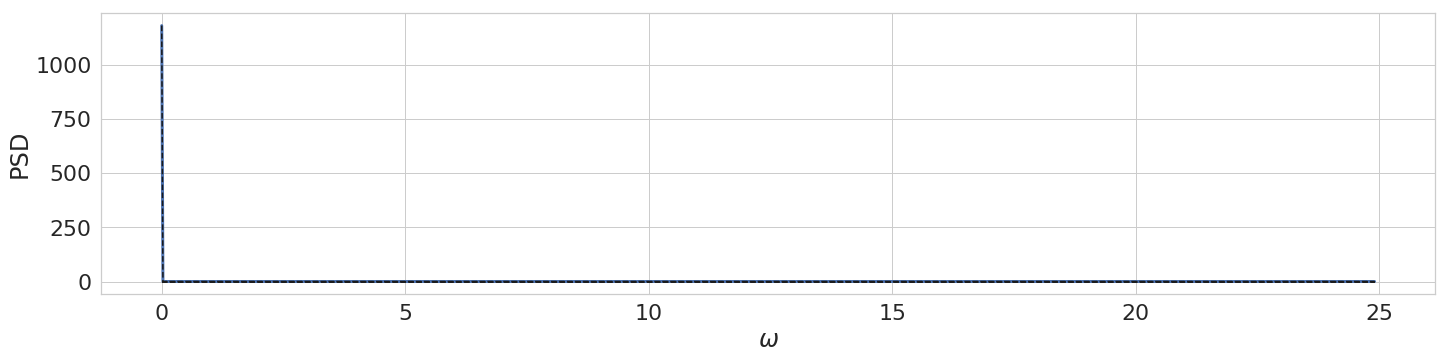

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -53.367951
  Number of iterations: 70
  Number of functions evaluations: 146
69.4303571977621


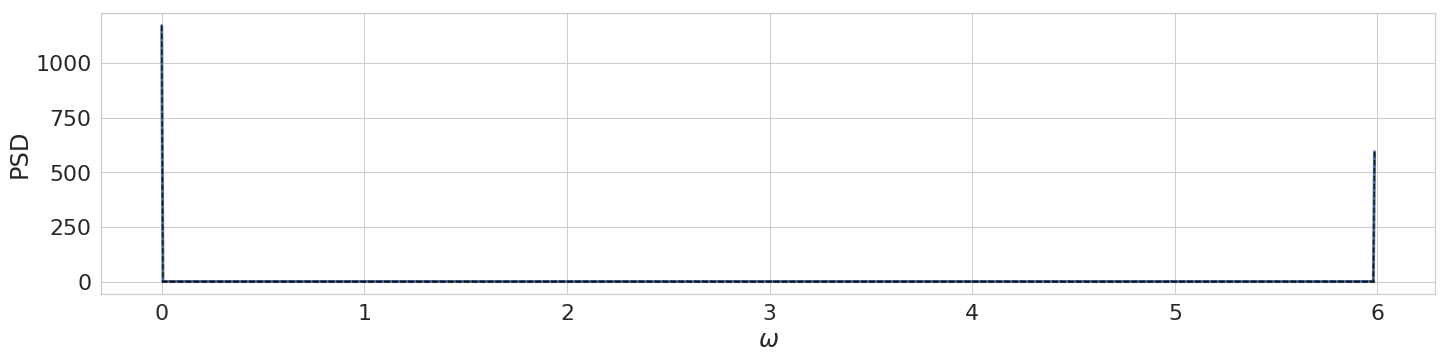

[{'constant': array([[-1.0978343 , -0.97131169, -0.51432661]]),
  'mean': array([6.28318531e-06]),
  'variance': array([1.e-06])},
 {'constant': array([[0.20356482, 0.95552942, 0.68024557]]),
  'mean': array([6.28318531e-06]),
  'variance': array([1.e-06])},
 {'constant': array([[0.91089049, 0.49894377, 1.5270233 ]]),
  'mean': array([5.98591554]),
  'variance': array([1.00024465e-06])}]

In [92]:
model_smlmc = mogptk.SM_LMC(data, Q=3)
model_smlmc.init_params(plot=True)
display(model_smlmc.get_params())

In [70]:
model_smlmc.train()
display(model_smlmc.get_params())

Building...


Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.489654
  Number of iterations: 44
  Number of functions evaluations: 52
Done


[{'constant': array([[0.00313486, 0.92760389, 0.96314945]]),
  'mean': array([6.28318748e-06]),
  'variance': array([1.e-06])},
 {'constant': array([[0.00605203, 1.78891595, 1.85747049]]),
  'mean': array([6.34437684e-06]),
  'variance': array([1.00000005e-06])},
 {'constant': array([[-0.68557086, -0.69031695, -0.43776993]]),
  'mean': array([6.00672934]),
  'variance': array([1.02717977e-06])}]

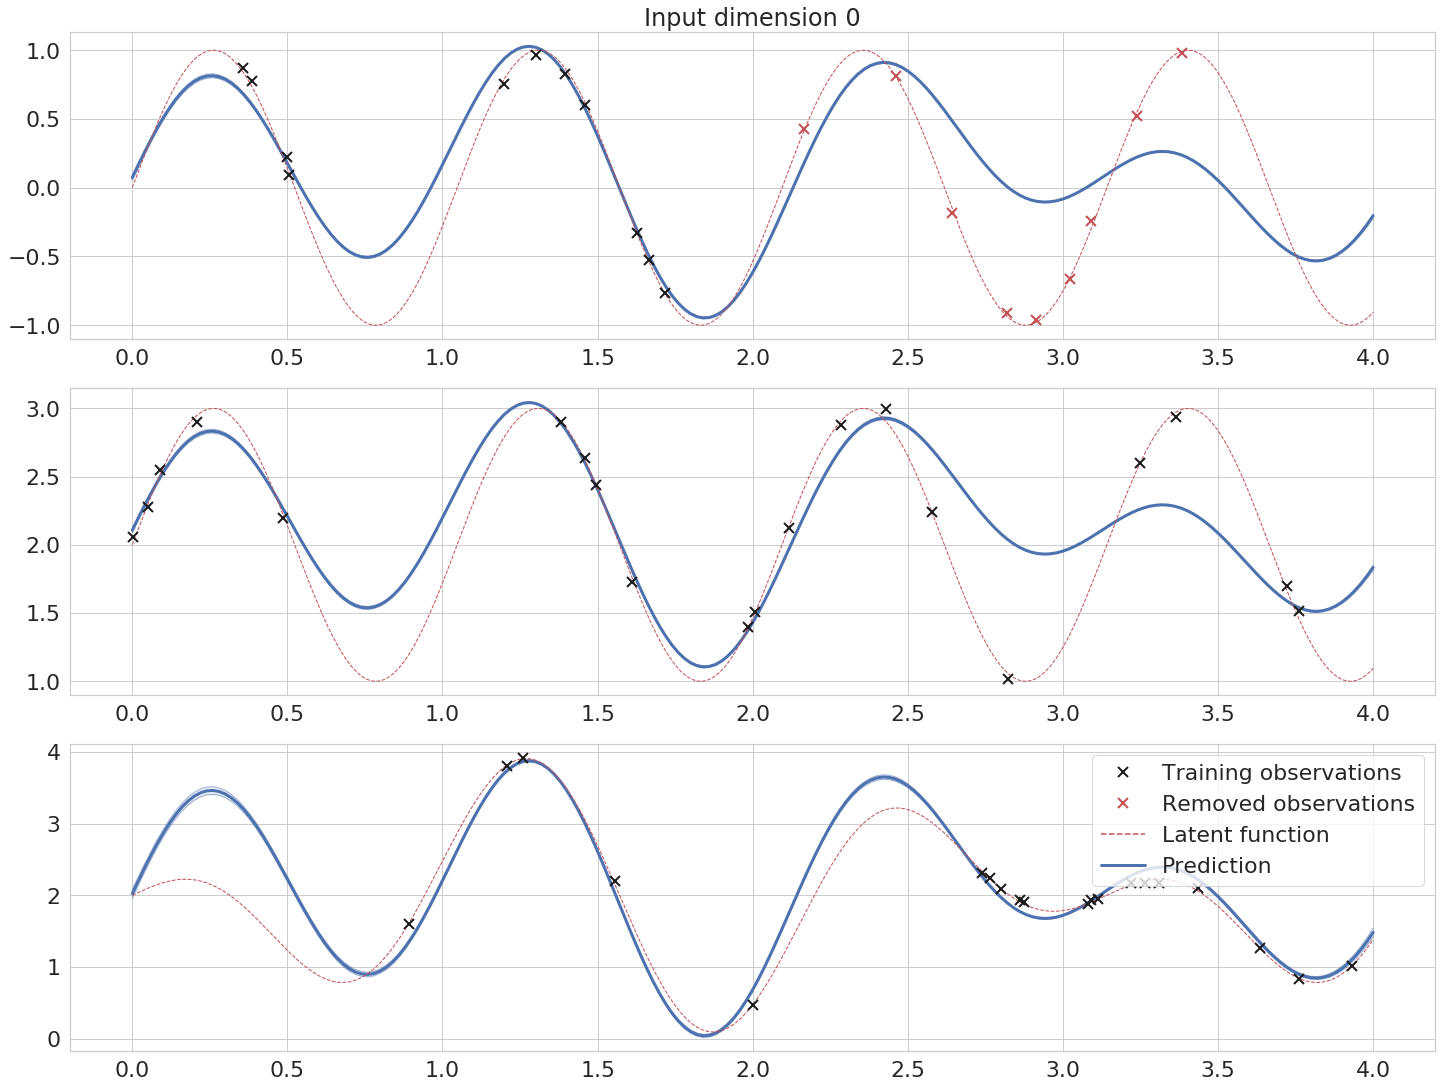

In [68]:
model_smlmc.set_prediction_range(channel='A', start=0, end=4, step=0.02)
model_smlmc.set_prediction_range(channel='B', start=0, end=4, step=0.02)
model_smlmc.set_prediction_range(channel='C', start=0, end=4, step=0.02)
model_smlmc.predict()

mogptk.plot(model_smlmc)

## Error estimation

In [24]:
mogptk.errors(model_mosm, model_csm, model_smlmc, model_cg, print=True)

,MAE,MAPE,MSE
model,,,
MOSM,0.140028,57.686263,0.031853
CSM,0.715704,99.784034,0.591840
SM-LMC,0.915930,153.181240,0.955272
